In [5]:
# trying to get a handle on uncertainty values
import os
import sys
import glob
import pickle
import copy
import numpy as np
import rmgpy.rmg.input  # note this method is currently broken for multiple reactors in an input file
import rmgpy.rmg.main
import rmgpy.chemkin
import rmgpy.tools.uncertainty
import rmgpy.kinetics.uncertainties

import rmgpy.tools.canteramodel
import random

import rmgpy.kinetics
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
def plot_thermos(thermos, labels=None, Tmin=300, Tmax=2000):
    if type(thermos) != list:
        thermos = [thermos]
    if labels is None:
        labels = ['' for t in thermos]
    linestyles = ['solid', 'solid', 'dashed', 'dashed']
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(12, 3)
    fig.tight_layout()
    ax[0].set_xlabel('Temperature (K)')
    ax[0].set_ylabel('H (kJ / mol)')
    ax[0].set_title('Enthalpy vs. Temperature')
    ax[1].set_xlabel('Temperature (K)')
    ax[1].set_ylabel('S (kJ / mol K)')
    ax[1].set_title('Entropy vs. Temperature')
    ax[2].set_xlabel('Temperature (K)')
    ax[2].set_ylabel('Cp (kJ / mol K)')
    ax[2].set_title('Heat Capacity vs. Temperature')
    T = np.linspace(Tmin, Tmax, 1001)
#     T = np.linspace(300, 3000, 1001)
    for n, thermo in enumerate(thermos):
        H = np.zeros(len(T))
        S = np.zeros(len(T))
        Cp = np.zeros(len(T))
        for i in range(0, len(T)):
            H[i] = thermo.get_enthalpy(T[i]) / 1000.0
            S[i] = thermo.get_entropy(T[i]) / 1000.0
            Cp[i] = thermo.get_heat_capacity(T[i]) / 1000.0
        ax[0].plot(T, H, linestyle=linestyles[n % len(linestyles)])
        ax[1].plot(T, S, linestyle=linestyles[n % len(linestyles)])
        ax[2].plot(T, Cp, linestyle=linestyles[n % len(linestyles)])
    # ax[0].legend(labels)
    # ax[1].legend(labels)
    # ax[2].legend(labels)
    ax[2].yaxis.get_major_formatter().set_useOffset(False)
    plt.subplots_adjust(wspace=0.25)
    plt.show()


In [8]:
thermo_lib_paths = glob.glob(os.path.join(rmgpy.settings['database.directory'], 'thermo', 'libraries', '*'))

In [19]:
# thermo_libs = [os.path.basename(x).replace('.py', '') for x in thermo_lib_paths]

thermo_libs = []
for i in range(len(thermo_lib_paths)):
    if 'surface' in thermo_lib_paths[i].lower():
        continue
    thermo_libs.append(os.path.basename(thermo_lib_paths[i]).replace('.py', ''))

In [27]:
def get_i_thing(thing, thing_list):
    for i in range(len(thing_list)):
        if thing.is_isomorphic(thing_list[i]):
            return i
    return None

In [20]:
# load all thermo libraries
database = rmgpy.data.rmg.RMGDatabase()
database.load(
    path = rmgpy.settings['database.directory'],
    thermo_libraries = thermo_libs,
    transport_libraries = [],
    reaction_libraries = [],
    seed_mechanisms = [],
    kinetics_families = [],
    kinetics_depositories = ['training'],
    depository = False,
)

In [21]:
# Pick a species, get the spread on uncertainty for it
my_species = rmgpy.species.Species(smiles='C')

In [43]:
# get the library value for every single 
results = {}
for lib in list(database.thermo.libraries.keys()):
    # is species in there?
    thermo_lib_item_list = [database.thermo.libraries[lib].entries[key].item \
                            for key in database.thermo.libraries[lib].entries.keys()]
    i_sp = get_i_thing(my_species.molecule[0], thermo_lib_item_list)
    if i_sp is None:
        continue

    thermo, library, entry = database.thermo.get_thermo_data_from_library(my_species, database.thermo.libraries[lib])
    if not isinstance(thermo, rmgpy.thermo.NASA):
        thermo = thermo.to_nasa(Tmin=200, Tmax=3000, Tint=1000)
    results[lib] = thermo

thermos = [results[key] for key in results.keys()]
thermo_labels = list(results.keys())

# Plot H, S, Cp zoomed out

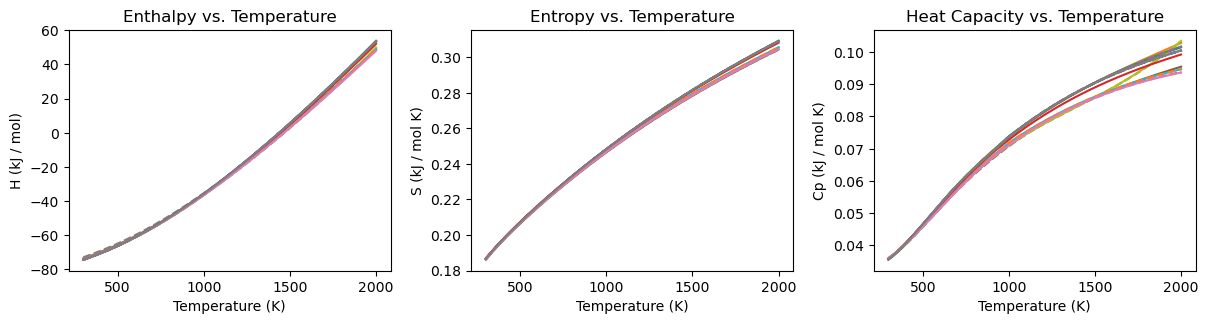

In [44]:
plot_thermos(thermos)

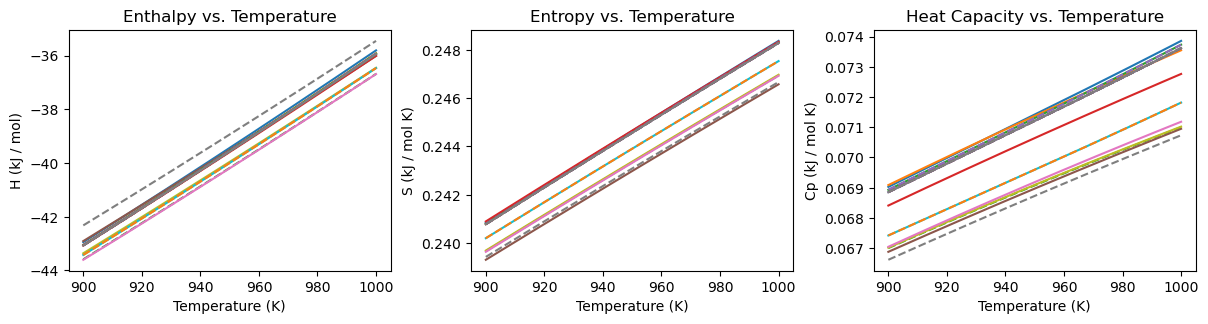

In [45]:
plot_thermos(thermos, Tmin=900, Tmax=1000)

# Plot Gibbs energy zoomed out

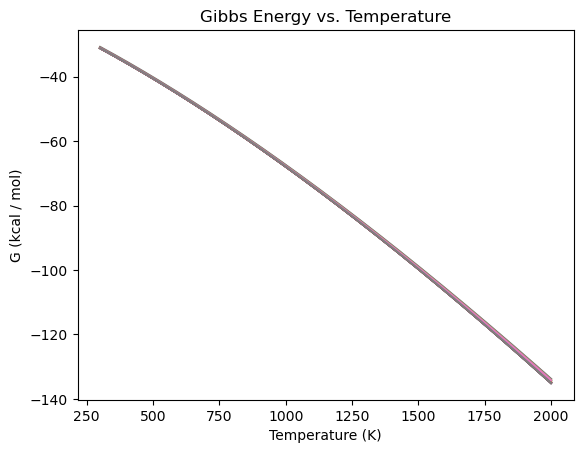

In [48]:
T = np.linspace(300, 2000, 1001)
for n, thermo in enumerate(thermos):
    G = np.zeros(len(T))
    for i in range(0, len(T)):
        G[i] = thermo.get_free_energy(T[i]) / 4184
    plt.plot(T, G)
   
ax = plt.gca()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('G (kcal / mol)')
ax.set_title('Gibbs Energy vs. Temperature')

ax.yaxis.get_major_formatter().set_useOffset(False)
plt.subplots_adjust(wspace=0.25)
plt.show()


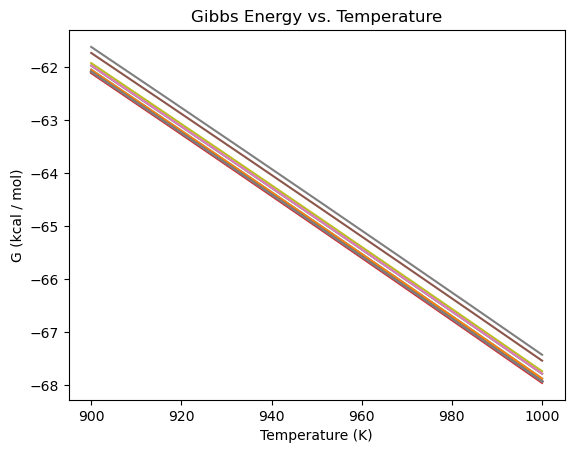

In [50]:
T = np.linspace(900, 1000, 1001)
for n, thermo in enumerate(thermos):
    G = np.zeros(len(T))
    for i in range(0, len(T)):
        G[i] = thermo.get_free_energy(T[i]) / 4184
    plt.plot(T, G)
   
ax = plt.gca()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('G (kcal / mol)')
ax.set_title('Gibbs Energy vs. Temperature')

ax.yaxis.get_major_formatter().set_useOffset(False)
plt.subplots_adjust(wspace=0.25)
plt.show()


# plot the spread on Gibbs Energies at different temperatures

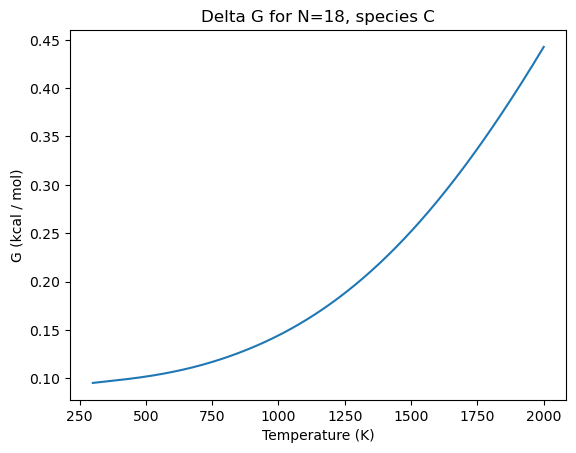

In [62]:
T = np.linspace(300, 2000, 1001)
Gs = np.zeros((len(thermos), len(T)))

for n, thermo in enumerate(thermos):
    for i in range(0, len(T)):
        Gs[n, i] = thermo.get_free_energy(T[i]) / 4184
    # plt.plot(T, Gs[n, :])
# mean = np.average(Gs, axis=0)
plt.plot(T, std_devs)
std_devs = np.std(Gs, axis=0)
ax = plt.gca()
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('G (kcal / mol)')
ax.set_title(f'Delta G for N={len(thermos)}, species {str(my_species.smiles)}')

ax.yaxis.get_major_formatter().set_useOffset(False)
plt.subplots_adjust(wspace=0.25)
plt.show()
